In [80]:
# Todos los imports
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from antlr4 import *
from JavaLexer import JavaLexer
from JavaParser import JavaParser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
import seaborn as sns

In [81]:
# ConPlag dataset import
def loadConPlag(train_path, test_path, labels_path):
    # Cargar los pares de entrenamiento y prueba
    train_pairs = pd.read_csv(train_path, header=None, names=['pair'])
    test_pairs = pd.read_csv(test_path, header=None, names=['pair'])

    # Cargar las etiquetas
    labels = pd.read_csv(labels_path)
    labels['pair'] = labels['sub1'] + '_' + labels['sub2']

    # Unir las etiquetas con los pares de entrenamiento y prueba
    train_pairs = train_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')
    test_pairs = test_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')

    print(f"Total de codigos cargados: {len(train_pairs) + len(test_pairs)}")

    return train_pairs, test_pairs

# Cargar los datos
train_pairs, test_pairs = loadConPlag(
    '../datasets/ConPlag/versions/train_pairs.csv',
    '../datasets/ConPlag/versions/test_pairs.csv',
    '../datasets/ConPlag/versions/labels.csv'
)

# contar cuantos plagios y no plagios hay en total
total_plagios = train_pairs['verdict'].value_counts().get('plagio', 0)
total_no_plagios = train_pairs['verdict'].value_counts().get('no_plagio', 0)


# Mostrar los primeros registros
print(train_pairs.head())
print("Columnas del DataFrame después de la unión:", train_pairs.columns)
print(train_pairs[['pair', 'verdict']].head())

# Función para cargar el código de los pares
def load_code(submission_id):
    folder_name = submission_id
    code1_id, code2_id = folder_name.split('_')

    # Rutas de los archivos de código
    code1_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code1_id}.java'
    code2_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code2_id}.java'

    # Leer el contenido de los archivos
    with open(code1_path, 'r', encoding='utf-8') as file:
        code1 = file.read()
    with open(code2_path, 'r', encoding='utf-8') as file:
        code2 = file.read()

    

    return code1, code2

# Cargar los códigos correspondientes a los pares de entrenamiento
train_pairs[['sub1', 'sub2']] = train_pairs['pair'].str.split('_', expand=True)
train_pairs[['code1', 'code2']] = train_pairs['pair'].apply(lambda x: load_code(x)).apply(pd.Series)


Total de codigos cargados: 911
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0
Columnas del DataFrame después de la unión: Index(['pair', 'verdict'], dtype='object')
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0


In [82]:
# IR-Plag-dataset import
def load_ir_plag_dataset(base_path):
    data = []
    
    for case_num in range(1, 8):
        case_folder = os.path.join(base_path, f'case-0{case_num}')
        
        # Original
        original_folder = os.path.join(case_folder, 'Original')
        original_file = os.listdir(original_folder)[0]
        original_code_path = os.path.join(original_folder, original_file)
        data.append({'type': 0, 'code': load_code(original_code_path)})
        
        # Non-plagiarized
        non_plag_folder = os.path.join(case_folder, 'non-plagiarized')
        for folder in os.listdir(non_plag_folder):
            folder_path = os.path.join(non_plag_folder, folder)
            for java_file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, java_file)
                if os.path.isfile(file_path):
                    data.append({'type': 0, 'code': load_code(file_path)})
        
        # Plagiarized
        plag_folder = os.path.join(case_folder, 'plagiarized')
        for folder in os.listdir(plag_folder):
            folder_path = os.path.join(plag_folder, folder)
            for sub_folder in os.listdir(folder_path):
                sub_folder_path = os.path.join(folder_path, sub_folder)
                for java_file in os.listdir(sub_folder_path):
                    file_path = os.path.join(sub_folder_path, java_file)
                    if os.path.isfile(file_path):
                        data.append({'type': 1, 'code': load_code(file_path)})
    
    return pd.DataFrame(data)
def load_code(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Cargar el IR-Plag-Dataset
ir_plag_dataset = load_ir_plag_dataset('../datasets/IR-Plag-Dataset')
print(ir_plag_dataset.head())

   type                                               code
0     0  \npublic class T1 {\n\tpublic static void main...
1     0  /*\n * To change this license header, choose L...
2     0  \n/**\n *\n * @author 65FBEF05E01FAC390CB3FA07...
3     0  \n\n/**\n *\n * @author CB6AB3315634A1E4D11B09...
4     0  /*\n * To change this license header, choose L...


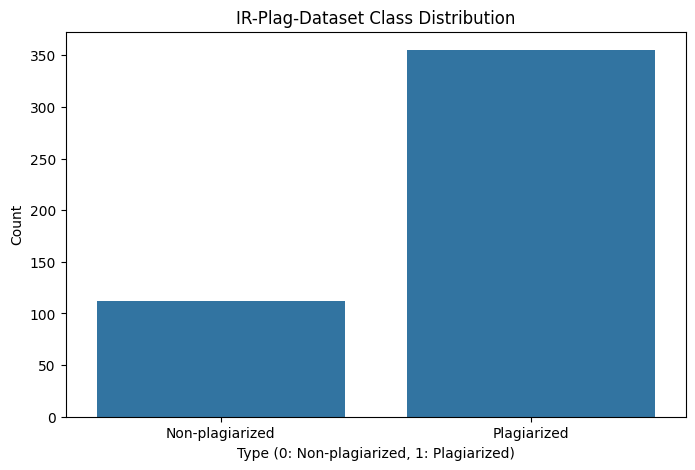

Total Non-plagiarized: 112
Total Plagiarized: 355


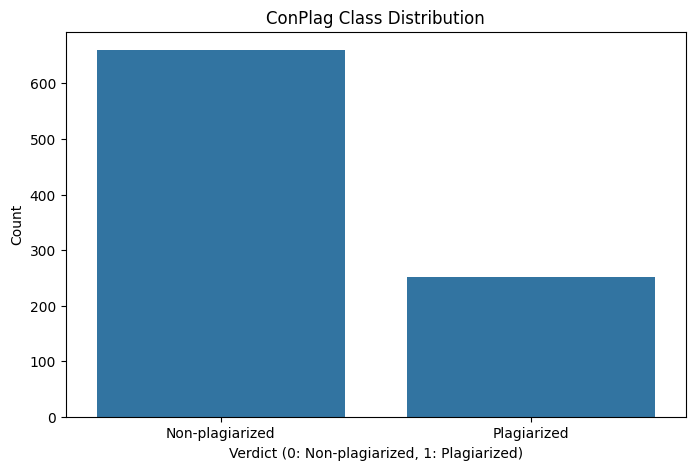

Total Plagiarized: 251 | Total Non-plagiarized: 660


In [83]:
# ver cantidad de plagios y no plagios en los datasets en graficas de barras

def plot_class_distribution(df, title):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='type', data=df)
    plt.title(title)
    plt.xlabel('Type (0: Non-plagiarized, 1: Plagiarized)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
    plt.show()
    print(f"Total Non-plagiarized: {df['type'].value_counts().get(0, 0)}")
    print(f"Total Plagiarized: {df['type'].value_counts().get(1, 0)}")

plot_class_distribution(ir_plag_dataset, 'IR-Plag-Dataset Class Distribution')
# Para ConPlag, usar la columna 'verdict' en vez de 'type'


def plot_conplag_distribution(df, title):
    total = train_pairs['verdict'].value_counts() + test_pairs['verdict'].value_counts()
    total = total.reindex([0, 1], fill_value=0)  # Asegurar que ambos valores estén presentes
    plt.figure(figsize=(8, 5))
    sns.barplot(x=total.index, y=total.values)
    plt.title(title)
    plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
    plt.show()
    print(f"Total Plagiarized: {total.get(1, 0)} | Total Non-plagiarized: {total.get(0, 0)}")
 

plot_conplag_distribution(train_pairs, 'ConPlag Class Distribution')

Estos valores no me agradan nada. Reviasré en linea si es verdad que está tan desbalanceado el dataset
y registraré mis resultados aqui

ConPlag:
- Plagio: 251
- No Plagio: 660



IR-Plag:
- Plagio: 355
- No Plagio: 105 + 7 (7 son los que no tienen etiqueta porque son los orignales)

Ahora si, todo tiene sentido. Los datasets están desbalanceados pero si se juntaran, sería un enorme dataset balancedo.

In [84]:
# Tokenizador de ANTLR para Java

# Lista de tokens a ignorar (personalizable)
JAVA_STOP_TOKENS.update({
    'throws', 'final', 'super', 'switch', 'case', 'default', 
    'break', 'continue', '@Test', 'assertEquals', 'import'
})


def tokenize_java(code):
        input_stream = InputStream(code)
        lexer = JavaLexer(input_stream)
        stream = CommonTokenStream(lexer)
        stream.fill()

        tokens = [
                token.text for token in stream.tokens 
                if (token.channel != Lexer.HIDDEN and 
                token.type != Token.EOF and 
                token.text not in JAVA_STOP_TOKENS)
        ]
        return tokens

In [85]:
# TF-IDF function
def compute_tfidf_similarity(code1, code2):
    # Tokenizar y preprocesar los códigos
    tokens1 = tokenize_java(code1)
    tokens2 = tokenize_java(code2)

    # Vectorizar los códigos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([' '.join(tokens1), ' '.join(tokens2)])

    # Calcular la similitud coseno
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    
    return similarity[0][0]

conplag = compute_tfidf_similarity(train_pairs.iloc[0]['code1'], train_pairs.iloc[0]['code2'])

irplag = compute_tfidf_similarity(ir_plag_dataset.iloc[0]['code'], ir_plag_dataset.iloc[1]['code'])

# Mostrar similitudes
print(f"Similitud ConPlag: {conplag:.4f}")
print(f"Similitud IR-Plag: {irplag:.4f}")

Similitud ConPlag: 0.5928
Similitud IR-Plag: 0.7665


In [86]:
# Función mejorada para calcular similitudes para todos los pares
def calculate_all_similarities(pairs_df):
    similarities = []
    for idx, row in pairs_df.iterrows():
        try:
            sim = compute_tfidf_similarity(row['code1'], row['code2'])
            similarities.append(sim)
        except Exception as e:
            print(f"Error procesando par {row['pair']}: {str(e)}")
            similarities.append(0)
    return np.array(similarities)

Threshold óptimo: 0.52, F1-score: 0.70


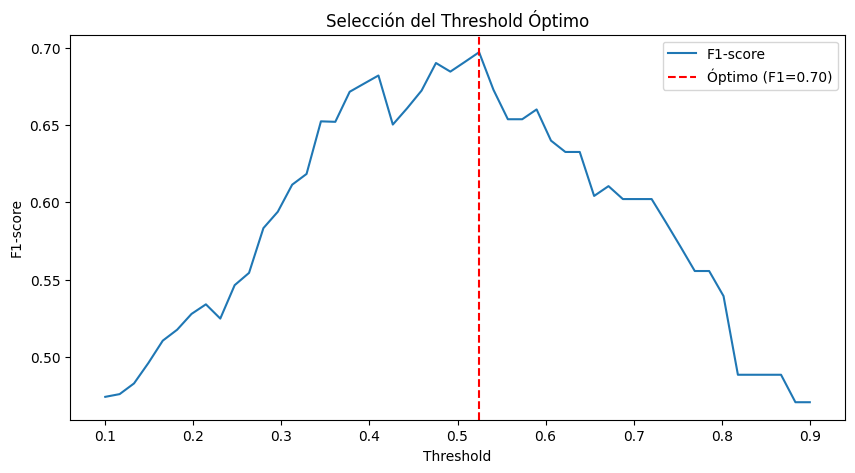

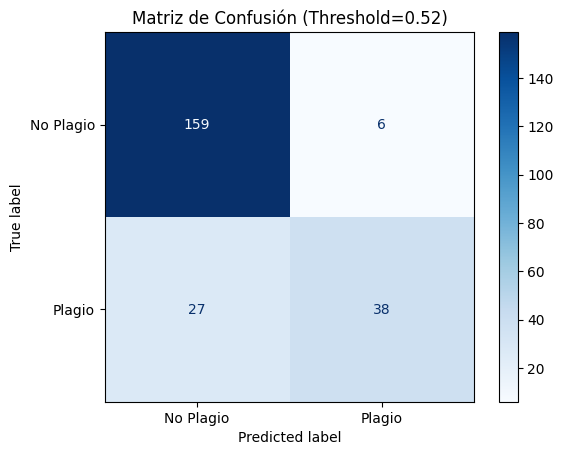

No Plagio: 186, Plagio: 44

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.96      0.91       165
           1       0.86      0.58      0.70        65

    accuracy                           0.86       230
   macro avg       0.86      0.77      0.80       230
weighted avg       0.86      0.86      0.85       230



In [87]:
# Calcular similitudes para ConPlag
train_pairs['similarity'] = calculate_all_similarities(train_pairs)

# Preparar etiquetas verdaderas (y_true)
y_true = train_pairs['verdict'].values

# Calcular threshold óptimo
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_true, train_pairs['similarity'] > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Threshold óptimo: {best_threshold:.2f}, F1-score: {best_f1:.2f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
# Prueba de otros thresholds
#best_threshold = 0.43
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo (F1={best_f1:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Selección del Threshold Óptimo')
plt.legend()
plt.show()




# Matriz de confusión con el threshold óptimo
y_pred = (train_pairs['similarity'] > best_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['No Plagio', 'Plagio'], 
                                        cmap=plt.cm.Blues) 
plt.title(f'Matriz de Confusión (Threshold={best_threshold:.2f})')
plt.show()

print(f'No Plagio: {np.sum(y_pred == 0)}, Plagio: {np.sum(y_pred == 1)}')

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred))